In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline   
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, brier_score_loss
from sklearn.ensemble import RandomForestClassifier, StackingClassifier,  BaggingClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import optuna
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("csv/train.csv", index_col=0)

## Feature engineering

In [3]:
def ft(data):
    data["hemoglobin_height"] = data["hemoglobin"] * data["height(cm)"]
    data["hemoglobin / Gtp"] = data["hemoglobin"] / data["Gtp"]
    data['BMI'] = data['weight(kg)'] / ((data['height(cm)'] / 100) ** 2)
    data['hemoglobin_status'] = [ 1 if ((age < 18 and 11.5 <= hgb <= 15.5) or (18 <= age <= 65 and 12.1 <= hgb <= 17.2) or (age > 65 and 11.7 <= hgb <= 14.9)) else 0 for age, hgb in zip(data['age'], data['hemoglobin'])]
    data['ALT_binned_quantile'] = pd.cut(data['ALT'], bins=4, labels=[1, 2, 3, 4])
    data['BMI_category'] = pd.cut(data['BMI'], bins=[0, 18.5, 25, 30, np.inf], labels = [1, 2, 3, 4])
    data['age_height'] = data['age'] * data['height(cm)']
            
ft(df)
X = df.drop(["smoking"], axis=1)  
y = df["smoking"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

df.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,Gtp,dental caries,smoking,hemoglobin_height,hemoglobin / Gtp,BMI,hemoglobin_status,ALT_binned_quantile,BMI_category,age_height
id,,,,,,,,,,,,,,,,,,,,,
0,55.0,170.0,80.0,92.0,1.2,0.8,1.0,1.0,129.0,74.0,...,13.0,0.0,0.0,2618.0,1.184615,27.681661,1,1,3,9350.0
1,30.0,170.0,80.0,94.0,1.5,1.5,1.0,1.0,128.0,84.0,...,92.0,0.0,1.0,2754.0,0.176087,27.681661,1,1,3,5100.0
2,45.0,170.0,75.0,84.0,1.0,1.0,1.0,1.0,124.0,80.0,...,50.0,0.0,1.0,2482.0,0.292000,25.951557,1,1,3,7650.0
3,55.0,150.0,55.0,85.0,0.9,0.5,1.0,1.0,123.0,79.0,...,18.0,0.0,0.0,2010.0,0.744444,24.444444,1,1,2,8250.0
4,45.0,160.0,55.0,72.0,0.5,0.6,1.0,1.0,117.0,76.0,...,10.0,0.0,0.0,2224.0,1.390000,21.484375,1,1,2,7200.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  15000 non-null  float64 
 1   height(cm)           15000 non-null  float64 
 2   weight(kg)           15000 non-null  float64 
 3   waist(cm)            15000 non-null  float64 
 4   eyesight(left)       15000 non-null  float64 
 5   eyesight(right)      15000 non-null  float64 
 6   hearing(left)        15000 non-null  float64 
 7   hearing(right)       15000 non-null  float64 
 8   systolic             15000 non-null  float64 
 9   relaxation           15000 non-null  float64 
 10  fasting blood sugar  15000 non-null  float64 
 11  Cholesterol          15000 non-null  float64 
 12  triglyceride         15000 non-null  float64 
 13  HDL                  15000 non-null  float64 
 14  LDL                  15000 non-null  float64 
 15  hemoglobin           150

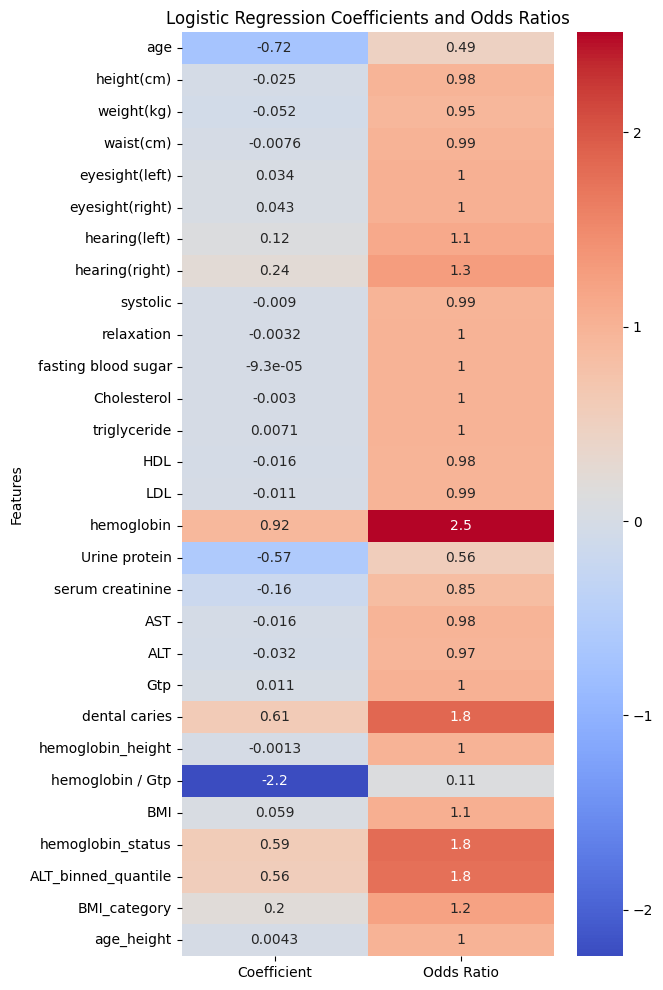

In [5]:
model = LogisticRegression(max_iter=10000)
model.fit(X, y)

coefficients = pd.DataFrame({
    'Coefficient': model.coef_[0],
    'Odds Ratio': np.exp(model.coef_[0])
}, index=X.columns)

plt.figure(figsize=(6, 12))
sns.heatmap(coefficients, annot=True, cmap="coolwarm", cbar=True)
plt.title("Logistic Regression Coefficients and Odds Ratios")
plt.ylabel("Features")
plt.show()

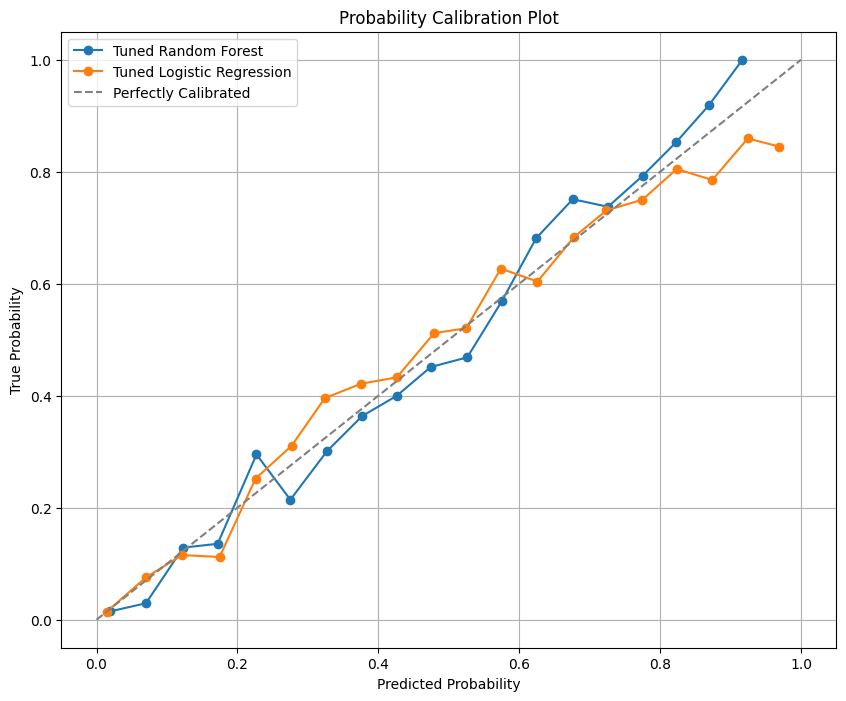

Brier score (Random Forest): 0.13343263424412555
ROC AUC (Random Forest): 0.8833342987032854
Brier score (Logistic Regression): 0.13751028542044091
ROC AUC (Logistic Regression): 0.8764379503689517


In [6]:
model = RandomForestClassifier(random_state=42, max_depth = 16,n_estimators=191, min_samples_split = 10, min_samples_leaf = 4, bootstrap= True,  max_features = 'log2', criterion='entropy')

model5 = Pipeline([
    ("rf", model)
])
model5.fit(X_train, y_train)
pred = model5.predict_proba(X_test)[:,1]

logic = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("logic", LogisticRegression())
])
logic.fit(X_train, y_train)

pred_log = logic.predict_proba(X_test)[:, 1]

prob_true_rf, prob_pred_rf = calibration_curve(y_test, pred, n_bins=20)
prob_true_log, prob_pred_log = calibration_curve(y_test, pred_log, n_bins=20)

plt.figure(figsize=(10, 8))
plt.plot(prob_pred_rf, prob_true_rf, marker='o', label='Tuned Random Forest')
plt.plot(prob_pred_log, prob_true_log, marker='o', label='Tuned Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='gray')

plt.title('Probability Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend(loc='best')
plt.grid()
plt.show()

b_rf = brier_score_loss(y_test, pred)
r_rf = roc_auc_score(y_test, pred)
print("Brier score (Random Forest):", b_rf)
print("ROC AUC (Random Forest):", r_rf)

b_log = brier_score_loss(y_test, pred_log)
r_log = roc_auc_score(y_test, pred_log)
print("Brier score (Logistic Regression):", b_log)
print("ROC AUC (Logistic Regression):", r_log)


In [7]:
def objective(trial):
    # Suggest hyperparameters to search
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 50)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    pipe = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("logic", LogisticRegression(penalty="elasticnet", solver="saga", C=67.71250104715932, l1_ratio=0.2318363725602379))
    ])


    estimators = [('rf', RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_split=min_samples_split,
                                            min_samples_leaf=min_samples_leaf,
                                            max_features=max_features,
                                            bootstrap=bootstrap,
                                            random_state=42,
                                            n_jobs=-1))]
    
    stacking = StackingClassifier(estimators=estimators, final_estimator=pipe)

    stacking.fit(X_train, y_train)

    pred_rf = stacking.predict_proba(X_test)[:, 1]    
    pred = stacking.predict(X_test)
    t = roc_auc_score(y_test, pred_rf)
    
    return t  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best Parameters:", study.best_params)
print("Best ROC-AUC:", study.best_value)

best_rf = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

test_roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
print("Test ROC-AUC:", test_roc_auc)

[I 2024-11-10 22:53:28,016] A new study created in memory with name: no-name-b62bac36-c516-435a-9f00-b9635e8d216c
[I 2024-11-10 22:53:33,779] Trial 0 finished with value: 0.8817911919645576 and parameters: {'n_estimators': 453, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 29, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.8817911919645576.
[I 2024-11-10 22:53:38,356] Trial 1 finished with value: 0.8823241610457736 and parameters: {'n_estimators': 316, 'max_depth': 28, 'min_samples_split': 28, 'min_samples_leaf': 23, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.8823241610457736.
[I 2024-11-10 22:53:42,689] Trial 2 finished with value: 0.8781028422400912 and parameters: {'n_estimators': 152, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 33, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.8823241610457736.
[I 2024-11-10 22:53:54,854] Trial 3 finished with value: 0.8804097581716

Best Parameters: {'n_estimators': 316, 'max_depth': 28, 'min_samples_split': 28, 'min_samples_leaf': 23, 'max_features': 'sqrt', 'bootstrap': True}
Best ROC-AUC: 0.8823241610457736
Test ROC-AUC: 0.8823241610457736


In [ ]:
base_model = RandomForestClassifier(random_state=42, max_depth = 16,n_estimators=191, min_samples_split = 10, min_samples_leaf = 4, bootstrap= True,  max_features = 'log2', criterion='entropy')

pipe = Pipeline([
    ("pca", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("logic", LogisticRegression(penalty="elasticnet", solver="saga", C=67.71250104715932, l1_ratio=0.2318363725602379))
])

bagging_model_l = BaggingClassifier(estimator=RandomForestClassifier(criterion='entropy', max_depth=30,
                    min_samples_leaf=7,
                    min_samples_split=21,
                    max_features = 'log2',
                    n_estimators=499,
                    bootstrap = False,
                    random_state=42), n_estimators=50, random_state=42, n_jobs = -1)

bagging_model = BaggingClassifier(estimator=base_model,
                                   n_estimators=50, 
                                   random_state=42,
                                   bootstrap_features=True,
                                   n_jobs = -1)



stacking = StackingClassifier(
    estimators=[
        ('bagging_rf', bagging_model_l),
        ('bagging_gb', bagging_model)
    ],
    final_estimator= pipe,
    cv=5, 
    n_jobs = -1
)


stacking.fit(X, y)
y_pred = stacking.predict_proba(X_test)[:,1]

accuracy = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")